<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузить данные и выполнить их ресемплирование по одному часу.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from lightgbm import LGBMRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import Pool, CatBoostRegressor, cv
from sklearn.dummy import DummyRegressor

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
except FileNotFoundError:
    data = pd.read_csv(r'C:\Users\ASUS\Desktop\Практикум\Data\taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
data = data.resample('1H').sum()

In [4]:
data.sort_index(inplace=True)

In [5]:
data.index.is_monotonic

True

In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
print("Начало :", data.index.min())
print("Конец :", data.index.max())

Начало : 2018-03-01 00:00:00
Конец : 2018-08-31 23:00:00


В первой части была проделанна работа:
- импортированны библиотеки
- загруженны данные
- был установлен иднекс таблицы по дате
- данные были ресемплированы по одному часу
- была проведена проверка в хронологическом ли порядке расположены даты и время

## Анализ

Проанализируйте данные.

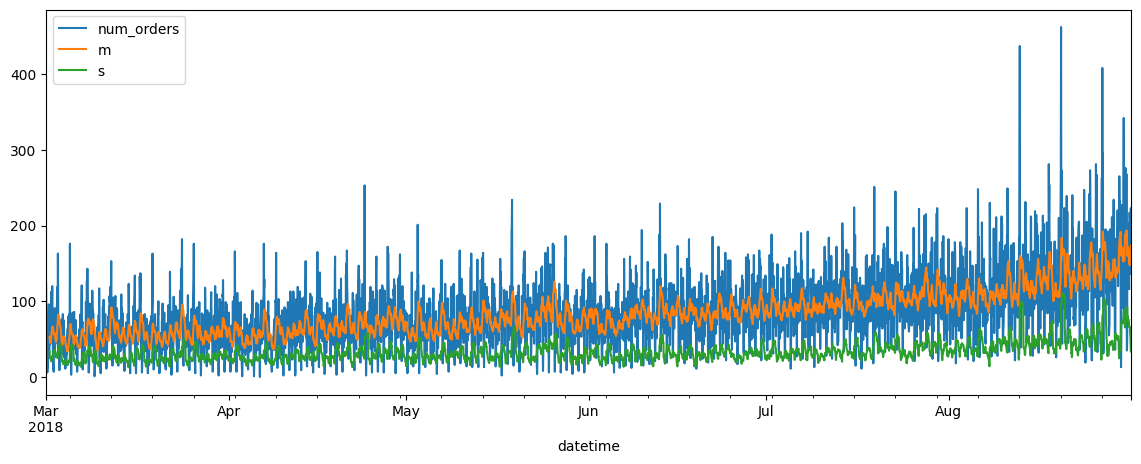

In [9]:
data['m'] = data['num_orders'].rolling(15).mean()
data['s'] = data['num_orders'].rolling(15).std()
data.plot(figsize=(14, 5));

In [10]:
del data['m']
del data['s']

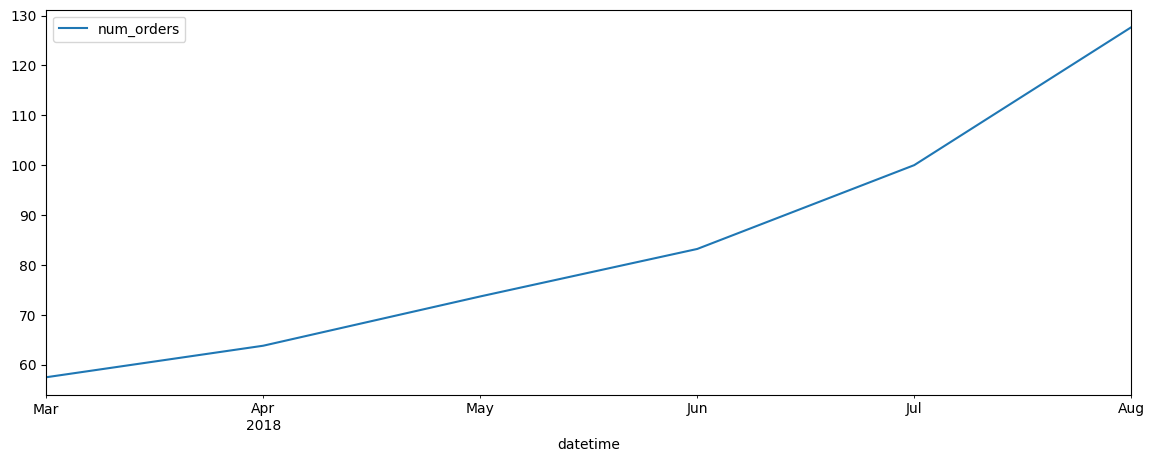

In [11]:
month = data.resample('1M').mean();
month.plot(figsize=(14, 5));

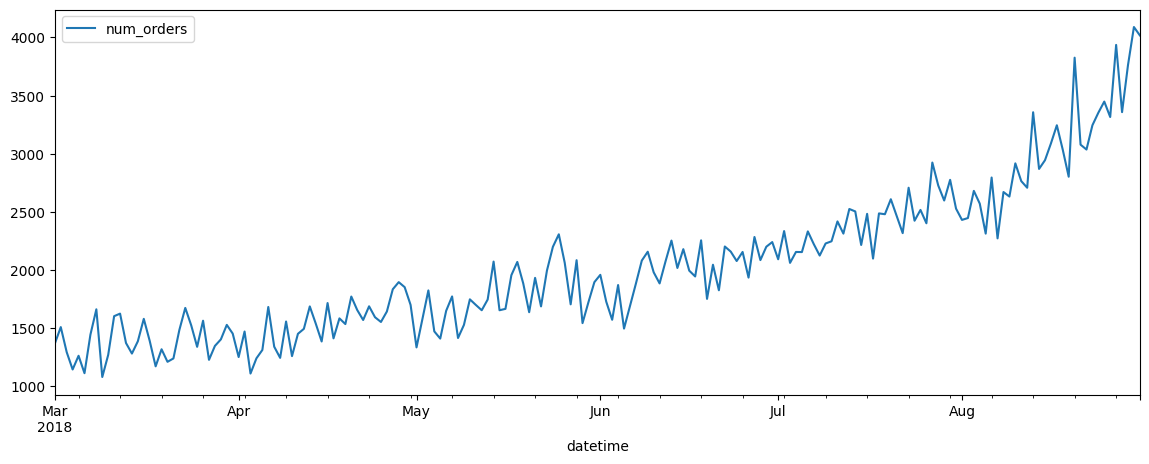

In [12]:
day = data.resample('1D').sum()
day.plot(figsize=(14, 5));

По графикам можно судить, что количество заказов со временем увеличивается.


In [13]:
decomposed = seasonal_decompose(data)

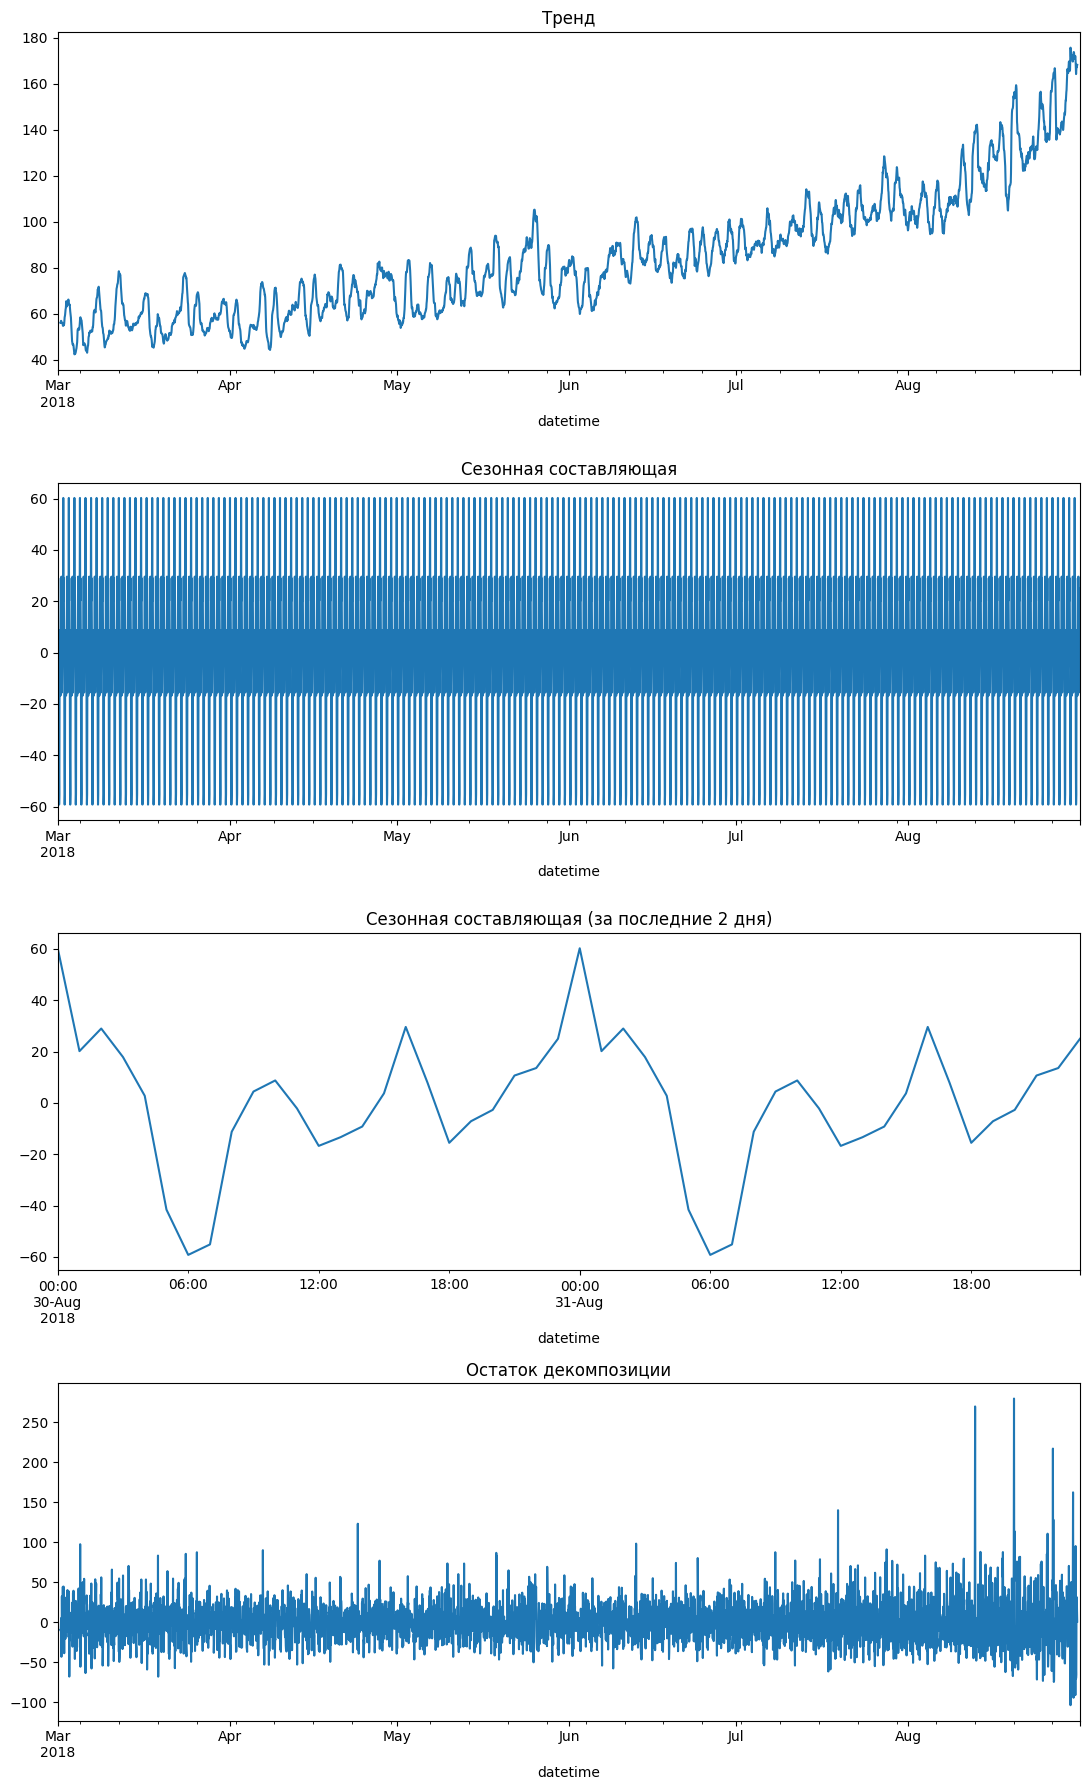

In [14]:
plt.figure(figsize=(11,18))

plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная составляющая')

plt.subplot(413)
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонная составляющая (за последние 2 дня)')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')

plt.tight_layout()


Рост заказов с начала марта по конец авгута скорее всего связан с ростом популярности приложения.

Минимум заказов - на утренний период в районе 6 утра, пик заказов приходится на полночь. Скорее всего это следствие того что еще не работуют автобусы/метро.

## Обучение

Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.

Изучим 3 модели: Линейная Регрессия,Случчайный лес и КэтБуст

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    taxi = data.copy()
    taxi['day'] = taxi.index.day
    taxi['hour'] = taxi.index.hour
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()
    return taxi

In [16]:
taxi = make_features(data, 10, 10)

In [17]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna() 

In [18]:
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train.num_orders
target_test = test.num_orders

pred_previous_train = train['num_orders'].shift()
pred_previous_train = pred_previous_train.dropna()

pred_previous_test = test['num_orders'].shift()
pred_previous_test[0] = train['num_orders'][-1]

In [19]:
tscv = TimeSeriesSplit()

In [20]:
model_linreg = LinearRegression()

mse_lr = cross_val_score(model_linreg, features_train, target_train, cv=tscv, scoring='neg_mean_squared_error').mean() * -1 

In [21]:
params = {}

model_linreg_cv = RandomizedSearchCV(model_linreg, params,
                                     scoring = 'neg_mean_squared_error', cv=tscv, 
                                     n_iter=1, n_jobs=-1
                                    )
model_linreg_cv.fit(features_train, target_train)
rmse_lr = mse_lr**0.5
print('RMSE на обучающей:',rmse_lr)

RMSE на обучающей: 32.95219289094184


In [22]:
param = {'n_estimators': range(1,1000,10), 'max_depth': range(1,31)}

In [23]:
model_rf = RandomForestRegressor(random_state = 12345)

model_rf_cv = RandomizedSearchCV(model_rf,
                                 param, scoring = 'neg_mean_squared_error', 
                                 cv=tscv, n_iter=1, n_jobs=-1
                                )

model_rf_cv.fit(features_train, target_train)
rmse_rf = (model_rf_cv.best_score_*-1)**0.5
print("RMSE на обучающей:", rmse_rf, model_rf_cv.best_params_)

RMSE на обучающей: 27.62310364591943 {'n_estimators': 161, 'max_depth': 7}


In [24]:
param_cat = {'learning_rate': [0.05, 0.1],'n_estimators': range(100, 500, 100)}
model_cat = CatBoostRegressor(learning_rate=0.5, random_state=12345,verbose=False, loss_function = "RMSE")

model_cat_cv = RandomizedSearchCV(model_cat,
                                 param_cat, scoring = 'neg_mean_squared_error', 
                                 cv=tscv, n_iter=1, n_jobs=-1,
                                )

model_cat_cv.fit(features_train, target_train)
rmse_cat = (model_cat_cv.best_score_ * -1) ** 0.5
print('RMSE на обучающей:', rmse_cat)


C:\Users\ASUS\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


RMSE на обучающей: nan


In [25]:
models = ['Linear Regression', 'Random Forest', 'CatBoost']
rmse = [rmse_lr, rmse_rf, rmse_cat]

df = pd.DataFrame({'Model': models, 'RMSE': rmse})
df

,Model,RMSE
0,Linear Regression,32.952193
1,Random Forest,27.623104
2,CatBoost,NaN


На тренировачной выборке лучший результат показала модель случайного леса 

## Тестирование

Проверьте данные на тестовой выборке и сделайте выводы.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [26]:
model_final = model_rf_cv.predict(features_test)
rmse_test = mean_squared_error(target_test, model_final) ** 0.5
print("RMSE на тестовой выборке лучшей модели: ", mean_squared_error(target_test, model_final, squared=False))

RMSE на тестовой выборке лучшей модели:  50.06552236192038


In [27]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
dummy_pred = dummy_regr.predict(features_test)
rmse_dummy = mean_squared_error(target_test, dummy_pred, squared=False)
print("RMSE на тестовой выборке для DummyRegressor: ", rmse_dummy)


RMSE на тестовой выборке для DummyRegressor:  84.69711915225858


Модель проходит проверку Дамми-регрессией

В ходе работы были подготовлены и проанализированны данные. Было проведено сравнениие 3х моделей на тренировочной выборке лучший результат показала модель случайного леса.
Данная модель была проверенна на тестовой выборке с итоговым RMSE 46.03653772210302 что удовлетворяет условиям задачи.
Так же модель была проверенна Дамми регрессией 